<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ). 

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение. 
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов. 

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [2]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [3]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [4]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [5]:
X[1].shape

(10,)

In [6]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [7]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [8]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

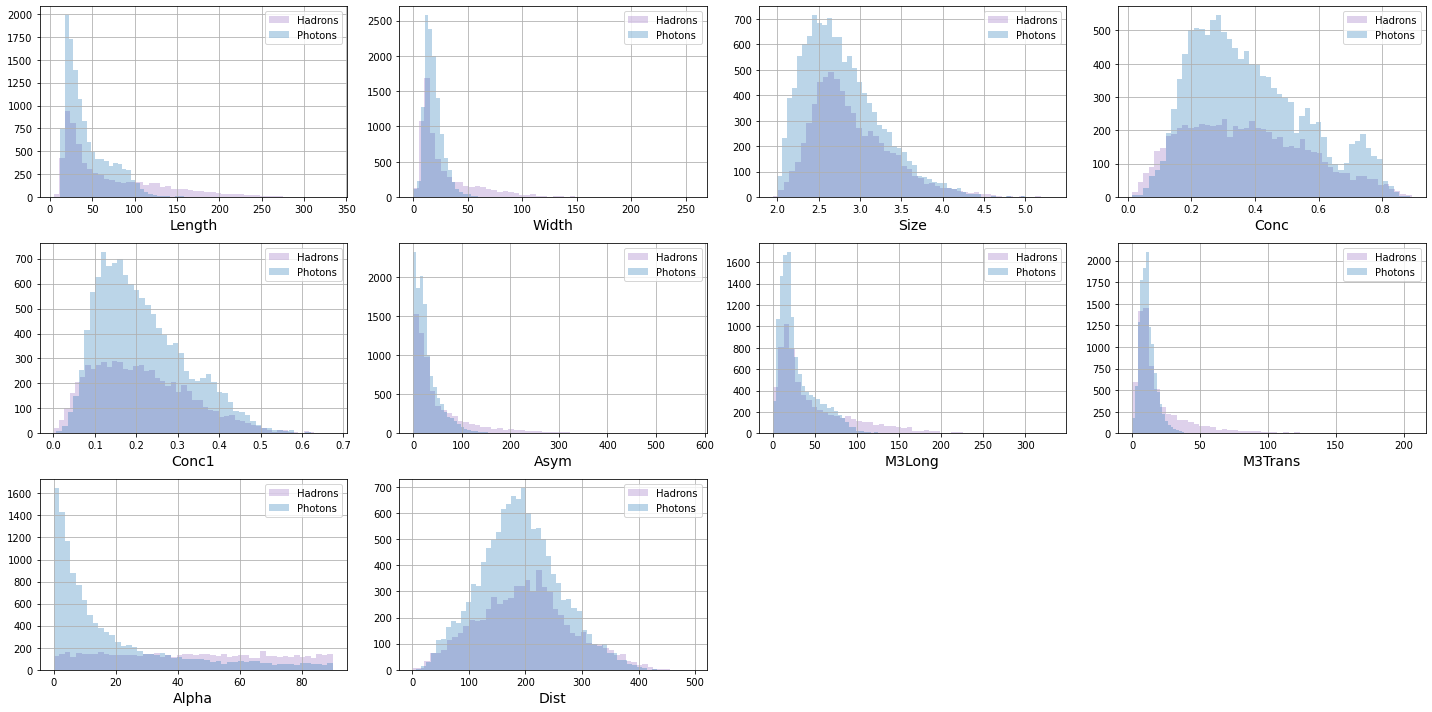

In [11]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [9]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size=0.5, shuffle = True, random_state = 11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

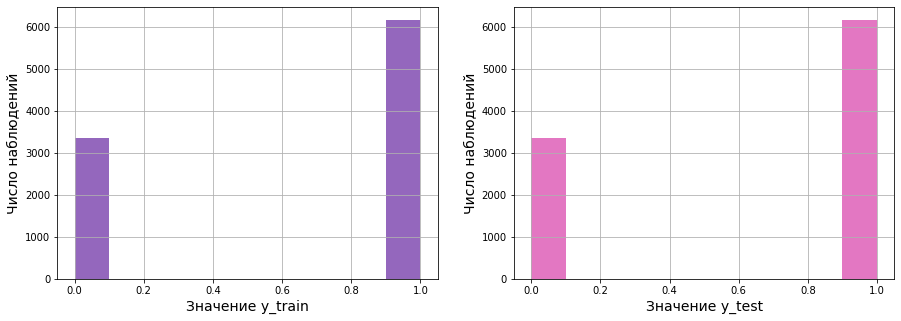

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(y_train, color="C4");
plt.xlabel("Значение y_train", size=14)
plt.ylabel("Число наблюдений", size=14)
plt.grid()
plt.subplot(1, 2, 2)
plt.hist(y_test, color="C6");
plt.xlabel("Значение y_test", size=14)
plt.ylabel("Число наблюдений", size=14)
plt.grid()


## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [10]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution='normal', random_state=0)
X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)

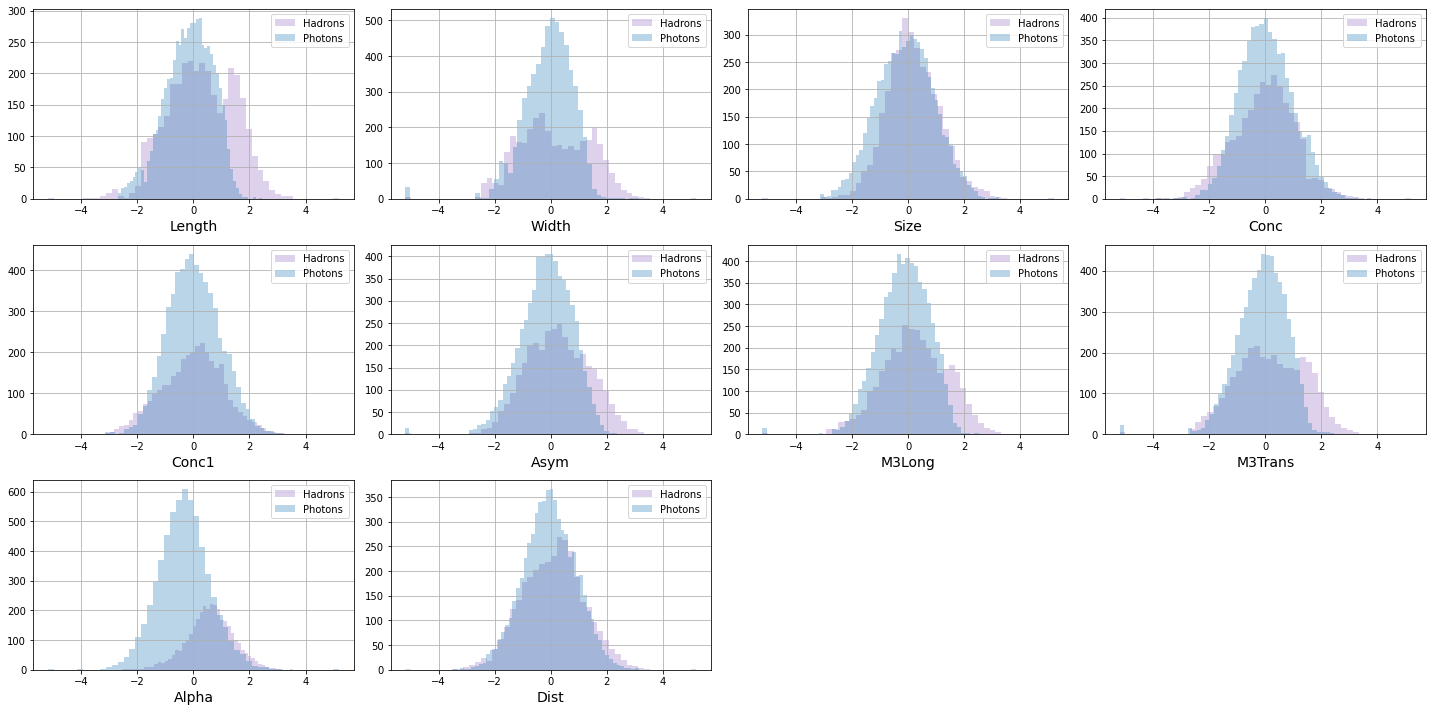

In [15]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

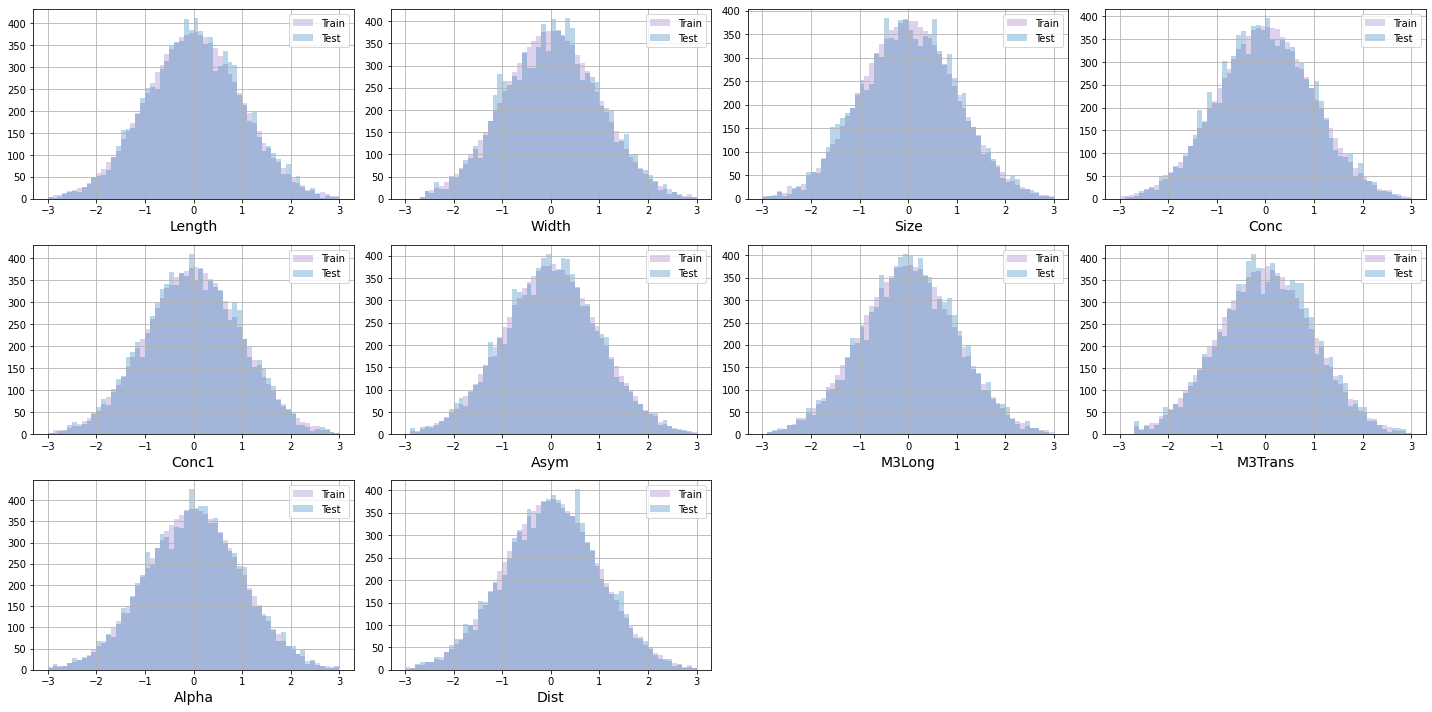

In [16]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения. 

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$. 

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
DEVICE

device(type='cpu')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [13]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        self.net = nn.Sequential(
            nn.Linear(self.n_inputs, 100), 
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, self.n_outputs)

        )


    def forward(self, z, y):
      
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [14]:
#Generate Fake Data: output like real data 

def generate(generator, y, latent_dim):
    z = torch.randn(y.shape[0], latent_dim) #.to(device)??
    X_fake = generator.forward(z, y) #нужно ли писать .forward?
    



    return X_fake  # numpy

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

Мне кажется, что не надо применять никакую функцию активации. Обычно мы используем сигмоиду, потому что мы хотим видеть вероятность от 0 до 1 в качестве вывода дискриминатора, но вы написали в условии, что дискриминатор выводит просто число, а не вероятность. Получается, ничего т не надо применять.

In [15]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()
        self.n_inputs = n_inputs
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100), 
            nn.ReLU(),
            nn.Linear(100, 100), 
            nn.ReLU(),
            nn.Linear(100, 1)
        )


    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        out = self.net(xy)
        return out #sigmoid

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель линейной регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

Чем меньше accuracy, тем по сути лучше у нас работает генератор, хотелось бы, чтобы accuracy постепенно падал до 0.5, тогда получится, что дискриминатор вообще запутался и не понимает, где фейк а где реальный, и просто наугад с одинаковой верояитностью ставит класс.


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

In [17]:
def other_agent_score(X_real, y_real, X_fake, y_fake):
    ### YOUR CODE IS HERE ######


    X = torch.cat((X_real, X_fake))
    y = torch.cat((y_real, y_fake))
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size = 0.25, shuffle = True, random_state = 11
    )
    X_train = X_train.detach().numpy()
    X_test = X_test.detach().numpy()
    y_train = y_train.detach().numpy()
    y_test = y_test.detach().numpy()



    clf = LogisticRegression(random_state=0)
    clf.fit(X_train, y_train)
    y_pred_logreg = clf.predict(X_test)
    print(y_train.shape, y_pred_logreg.shape)
    lin_reg_score = accuracy_score(y_test, y_pred_logreg)


    bst = XGBClassifier() #n_estimators=k, max_depth=j, learning_rate=i 
    bst.fit(X_train, y_train)
    y_pred_boost = bst.predict(X_test)
    boosting_score = accuracy_score(y_test, y_pred_boost)
    ### THE END OF YOUR CODE ###
    print('Linear regression score: ' + str(lin_reg_score))
    print('Boosting score: ' + str(boosting_score))

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Подсказка 1: не забывайте ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора.
- Подсказка 2: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 3: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [18]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                fake_batch = generate(self.generator, cond_batch, self.latent_dim)
                ### YOUR CODE IS HERE ######
                Fake_label = torch.ones(real_batch.shape[0])
                Real_label = torch.zeros(fake_batch.shape[0])


                real_objects_scores, gen_objects_scores = torch.split(
                self.discriminator(torch.cat([real_batch, fake_batch], dim=0), torch.unsqueeze(torch.cat([Real_label, Fake_label]), 1)),
                real_batch.shape[0],
            )
                if i == 0: 
                   # делаем шаг обучения генератора
                    self.opt_gen.zero_grad()
                    gen_loss = -torch.mean(self.discriminator(fake_batch, cond_batch))
                    gen_loss.backward()
                    self.opt_gen.step()
                    # gen_loss_trace.append((iter_i, gen_loss.item())) # нужна ли эта строчка вообще?

                elif (i % (self.n_critic+ 1)) == 0:
                
                    # делаем шаг обучения генератора
                    self.opt_gen.zero_grad()
                    gen_loss = -torch.mean(self.discriminator(fake_batch, cond_batch))
                    gen_loss.backward()
                    self.opt_gen.step()
                    # gen_loss_trace.append((iter_i, gen_loss.item())) # нужна ли эта строчка вообще?

                else:
                    # делаем шаг обучения дискриминатора
                    self.opt_disc.zero_grad()
                    discr_loss = - torch.mean(self.discriminator(real_batch, cond_batch)) + torch.mean(self.discriminator(fake_batch, cond_batch))
                    discr_loss.backward()
                    self.opt_disc.step()
                    #discr_loss_trace.append((iter_i, discr_loss.item()))
                    for p in self.discriminator.parameters():
                      p.data.clamp_(-0.01, 0.01)



            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())
            
            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов 
            # И запустите работу фукнции other_agent_score
            
      
            X_fake_oas = generate(self.generator, y_cond[:1000], self.latent_dim)
            X_real_oas = X_real[:1000]
            y_real_oas = torch.ones(1000)
            y_fake_oas = torch.zeros(1000)
            other_agent_score(X_real_oas, y_real_oas, X_fake_oas, y_fake_oas) 




  
            
        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [25]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

(1500,) (500,)
Linear regression score: 0.774
Boosting score: 0.976
(1500,) (500,)
Linear regression score: 0.7
Boosting score: 0.97
(1500,) (500,)
Linear regression score: 0.616
Boosting score: 0.954
(1500,) (500,)
Linear regression score: 0.528
Boosting score: 0.948
(1500,) (500,)
Linear regression score: 0.534
Boosting score: 0.948
(1500,) (500,)
Linear regression score: 0.506
Boosting score: 0.928
(1500,) (500,)
Linear regression score: 0.59
Boosting score: 0.928
(1500,) (500,)
Linear regression score: 0.674
Boosting score: 0.934
(1500,) (500,)
Linear regression score: 0.652
Boosting score: 0.924
(1500,) (500,)
Linear regression score: 0.602
Boosting score: 0.902
(1500,) (500,)
Linear regression score: 0.542
Boosting score: 0.866
(1500,) (500,)
Linear regression score: 0.596
Boosting score: 0.854
(1500,) (500,)
Linear regression score: 0.522
Boosting score: 0.82
(1500,) (500,)
Linear regression score: 0.612
Boosting score: 0.854
(1500,) (500,)
Linear regression score: 0.572
Boostin

<ipython-input-26-684ea810ad15>:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")


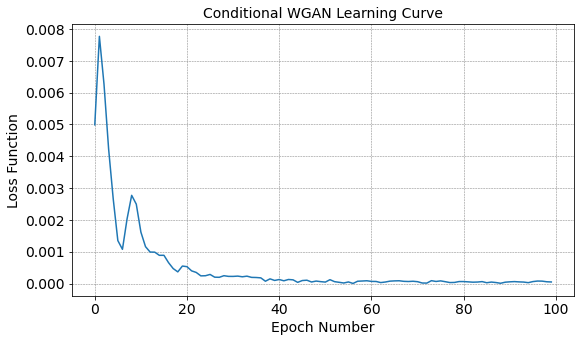

In [26]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [27]:
X_train_inversed = qt.inverse_transform(X_train)
X_test_inversed = qt.inverse_transform(X_test)

In [28]:



X_fake_train = generate(fitter.generator, torch.tensor(y_train, dtype=torch.float), latent_dim)

In [29]:

X_fake_train = X_fake_train.detach().numpy()
X_fake_train_inversed = qt.inverse_transform(X_fake_train)

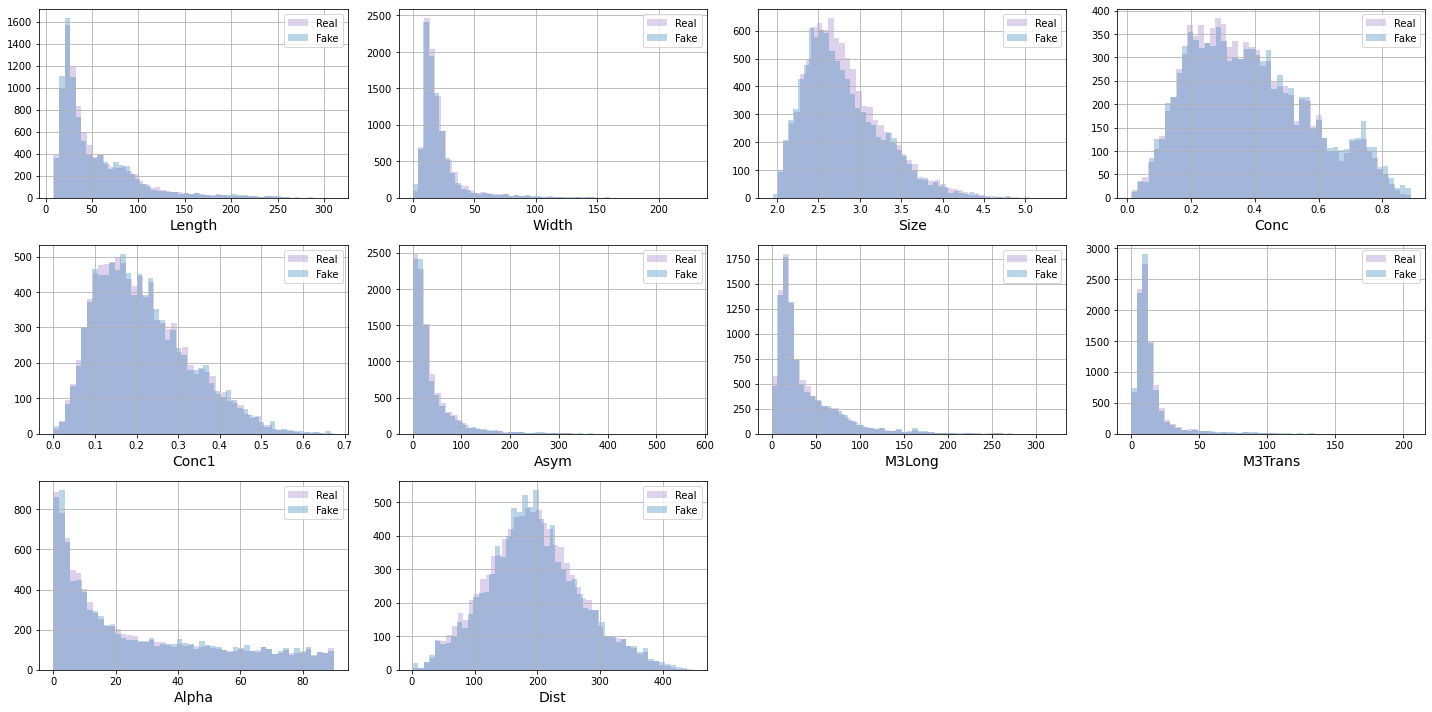

In [30]:
plot_hists(X_train_inversed, X_fake_train_inversed, names, label1="Real", label2="Fake", bins=50)

In [31]:
X_fake_test = generate(fitter.generator, torch.tensor(y_test, dtype=torch.float), latent_dim)
X_fake_test = X_fake_test.detach().numpy()
X_fake_test_inversed = qt.inverse_transform(X_fake_test)

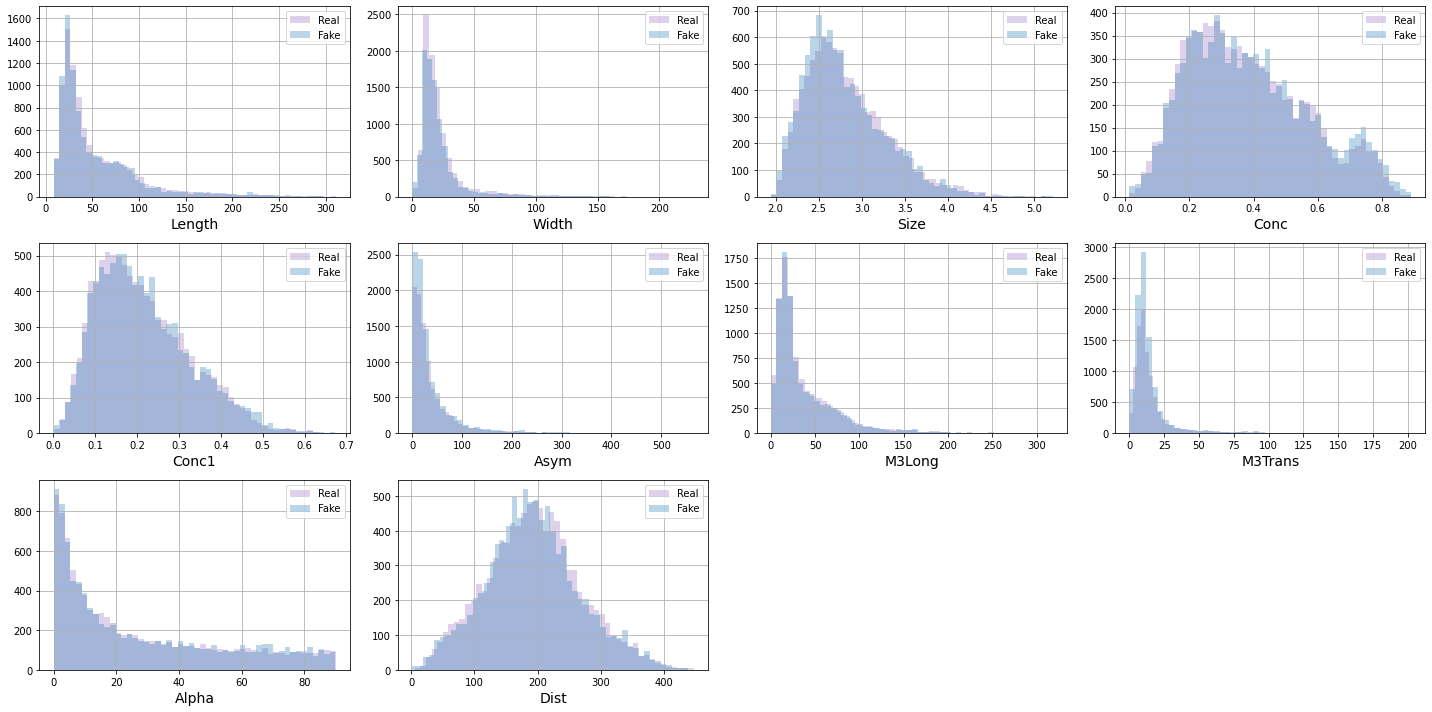

In [32]:
plot_hists(X_test_inversed, X_fake_test_inversed, names, label1="Real", label2="Fake", bins=50)

## Вывод: 
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [33]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [35]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.689181391882583


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


Эксперимент показал очень хорошие результаты судя по графикам - наши полученные распределения почти идентичны с исходными. Accuracy падает, что значит, что мы постепенно учим все лучший генератор.

Наша цель - генерить хорошие картинки, которые дискриминатор не сможет отличить от реальных, поэтому нам нужен аук рок около 0.5, тогда классификатор будет отличать картинки не лучше чем просто рандомо наугад.

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [34]:
def corrupt(x, amount): # x должен подаваться как tensor torch.tensor(x)
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1)
    x =  x * (1 - amount) + noise * amount
    return x

## Добавим sсheduler, он пригодится вам при обучении модели

In [20]:
!pip install diffusers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:

from diffusers import DDPMScheduler, UNet2DModel

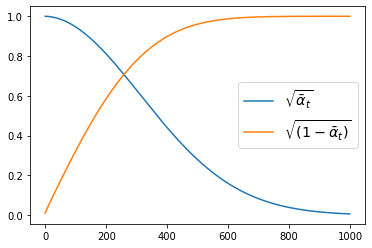

In [22]:

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, clip_sample_range=3)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?). 

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [23]:

class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        self.net = nn.Sequential(
            nn.Linear(self.n_inputs, 100), 
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, self.n_outputs)

        )

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [24]:
from tqdm import tqdm

In [25]:
def generate_with_diffusion(model, y, latent_dim, scheduler):
    ### YOUR CODE IS HERE ######
    X_fake = torch.randn(y.shape[0], latent_dim)
    for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

      # Get model pred
      with torch.no_grad():
          residual = model.forward(X_fake, y)  

      # Update sample with step
      X_fake = noise_scheduler.step(residual, t, X_fake).prev_sample
    ### THE END OF YOUR CODE ###
    return X_fake  # numpy

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [35]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
        
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []
        loss_fn = nn.MSELoss()
        # Fit GAN
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            j = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######
                noise = torch.randn_like(real_batch)
                timesteps = torch.randint(0, 999, (real_batch.shape[0],)).long()
                noisy_x = noise_scheduler.add_noise(real_batch, noise, timesteps)

                pred = self.model.forward(noisy_x, cond_batch)

                loss = loss_fn(pred, noise)

                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()
                
                loss_epoch += loss
                j+= 1
            loss_epoch = loss_epoch/j
                
                
                ### THE END OF YOUR CODE ###
            self.model.train(False)

            # caiculate and store loss after an epoch
            
            self.loss_history.append(loss_epoch.detach().numpy())
            
            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов 
            # И запустите работу фукнции other_agent_score
            
            ### YOUR CODE IS HERE ######
            X_fake_oas = generate_with_diffusion(self.model, y_cond[:1000], self.latent_dim, noise_scheduler)
            X_real_oas = X_real[:1000]
            y_real_oas = torch.ones(1000)
            y_fake_oas = torch.zeros(1000)
            other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas) 

            ### THE END OF YOUR CODE ###
            
        # Turn off training
        self.model.train(False)

In [36]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

1000it [00:02, 374.35it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.608
Boosting score: 0.918


1000it [00:01, 589.39it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.618
Boosting score: 0.796


1000it [00:01, 582.23it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.528
Boosting score: 0.774


1000it [00:01, 581.39it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.566
Boosting score: 0.764


1000it [00:01, 509.71it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.562
Boosting score: 0.756


1000it [00:02, 468.21it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.536
Boosting score: 0.736


1000it [00:01, 609.61it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.554
Boosting score: 0.73


1000it [00:01, 605.52it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.536
Boosting score: 0.74


1000it [00:01, 572.74it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.592
Boosting score: 0.716


1000it [00:02, 458.98it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.528
Boosting score: 0.75


1000it [00:01, 558.30it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.546
Boosting score: 0.756


1000it [00:01, 576.31it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.526
Boosting score: 0.728


1000it [00:01, 584.35it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.526
Boosting score: 0.758


1000it [00:01, 562.02it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.52
Boosting score: 0.72


1000it [00:02, 376.04it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.502
Boosting score: 0.754


1000it [00:01, 602.93it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.54
Boosting score: 0.782


1000it [00:01, 579.66it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.586
Boosting score: 0.754


1000it [00:01, 603.75it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.566
Boosting score: 0.766


1000it [00:01, 514.59it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.574
Boosting score: 0.742


1000it [00:02, 457.34it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.588
Boosting score: 0.78


1000it [00:01, 595.30it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.512
Boosting score: 0.776


1000it [00:01, 598.35it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.524
Boosting score: 0.748


1000it [00:01, 602.64it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.608
Boosting score: 0.79


1000it [00:02, 423.46it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.554
Boosting score: 0.722


1000it [00:01, 575.40it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.57
Boosting score: 0.78


1000it [00:01, 563.36it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.59
Boosting score: 0.726


1000it [00:01, 595.06it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.58
Boosting score: 0.79


1000it [00:01, 611.83it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.502
Boosting score: 0.74


1000it [00:02, 386.16it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.552
Boosting score: 0.756


1000it [00:01, 598.80it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.522
Boosting score: 0.728


1000it [00:01, 583.50it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.518
Boosting score: 0.766


1000it [00:01, 600.60it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.626
Boosting score: 0.776


1000it [00:01, 587.49it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.568
Boosting score: 0.754


1000it [00:02, 441.58it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.592
Boosting score: 0.776


1000it [00:01, 585.25it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.598
Boosting score: 0.74


1000it [00:01, 600.00it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.578
Boosting score: 0.766


1000it [00:01, 611.39it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.546
Boosting score: 0.756


1000it [00:03, 310.44it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.552
Boosting score: 0.754


1000it [00:01, 611.01it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.532
Boosting score: 0.794


1000it [00:01, 615.57it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.49
Boosting score: 0.69


1000it [00:01, 586.96it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.566
Boosting score: 0.77


1000it [00:01, 612.96it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.53
Boosting score: 0.758


1000it [00:02, 388.95it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.514
Boosting score: 0.75


1000it [00:01, 589.94it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.56
Boosting score: 0.776


1000it [00:01, 557.90it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.56
Boosting score: 0.754


1000it [00:01, 600.06it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.564
Boosting score: 0.762


1000it [00:01, 573.14it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.62
Boosting score: 0.734


1000it [00:02, 461.69it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.57
Boosting score: 0.74


1000it [00:01, 594.39it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.57
Boosting score: 0.748


1000it [00:01, 595.38it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.494
Boosting score: 0.74


1000it [00:01, 571.41it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.622
Boosting score: 0.75


1000it [00:02, 462.16it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.554
Boosting score: 0.742


1000it [00:01, 538.10it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.576
Boosting score: 0.81


1000it [00:01, 588.41it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.66
Boosting score: 0.746


1000it [00:01, 596.44it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.542
Boosting score: 0.716


1000it [00:01, 607.53it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.53
Boosting score: 0.758


1000it [00:02, 392.70it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.54
Boosting score: 0.74


1000it [00:01, 618.53it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.512
Boosting score: 0.724


1000it [00:01, 608.28it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.536
Boosting score: 0.726


1000it [00:01, 592.26it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.568
Boosting score: 0.758


1000it [00:01, 622.84it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.544
Boosting score: 0.75


1000it [00:02, 372.82it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.526
Boosting score: 0.76


1000it [00:01, 610.31it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.558
Boosting score: 0.74


1000it [00:01, 622.12it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.562
Boosting score: 0.728


1000it [00:01, 598.34it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.506
Boosting score: 0.716


1000it [00:01, 570.26it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.558
Boosting score: 0.766


1000it [00:02, 447.60it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.516
Boosting score: 0.76


1000it [00:01, 615.81it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.558
Boosting score: 0.756


1000it [00:01, 595.48it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.568
Boosting score: 0.764


1000it [00:01, 614.26it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.554
Boosting score: 0.752


1000it [00:02, 482.71it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.544
Boosting score: 0.726


1000it [00:01, 506.84it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.564
Boosting score: 0.748


1000it [00:01, 609.53it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.586
Boosting score: 0.714


1000it [00:01, 612.66it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.524
Boosting score: 0.696


1000it [00:01, 582.59it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.566
Boosting score: 0.738


1000it [00:02, 441.55it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.552
Boosting score: 0.724


1000it [00:01, 618.82it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.544
Boosting score: 0.73


1000it [00:01, 606.95it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.538
Boosting score: 0.75


1000it [00:01, 586.88it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.538
Boosting score: 0.74


1000it [00:01, 614.21it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.522
Boosting score: 0.738


1000it [00:02, 390.93it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.514
Boosting score: 0.74


1000it [00:01, 578.41it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.542
Boosting score: 0.712


1000it [00:01, 606.09it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.572
Boosting score: 0.756


1000it [00:01, 580.32it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.546
Boosting score: 0.74


1000it [00:01, 609.17it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.558
Boosting score: 0.728


1000it [00:02, 434.46it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.506
Boosting score: 0.764


1000it [00:01, 588.83it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.532
Boosting score: 0.724


1000it [00:02, 427.51it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.502
Boosting score: 0.702


1000it [00:01, 568.66it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.522
Boosting score: 0.726


1000it [00:02, 382.17it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.54
Boosting score: 0.746


1000it [00:01, 616.01it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.506
Boosting score: 0.71


1000it [00:01, 606.81it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.54
Boosting score: 0.744


1000it [00:01, 596.88it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.554
Boosting score: 0.756


1000it [00:01, 601.01it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.546
Boosting score: 0.742


1000it [00:02, 414.66it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.54
Boosting score: 0.696


1000it [00:01, 590.67it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.528
Boosting score: 0.732


1000it [00:01, 584.87it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.534
Boosting score: 0.758


1000it [00:01, 581.37it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.536
Boosting score: 0.678


1000it [00:01, 507.85it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.57
Boosting score: 0.728


1000it [00:02, 485.30it/s]
<ipython-input-35-fba26882c2f2>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_agent_score(X_real_oas, y_real_oas, torch.tensor(X_fake_oas), y_fake_oas)


(1500,) (500,)
Linear regression score: 0.554
Boosting score: 0.696
CPU times: user 4min 35s, sys: 11.8 s, total: 4min 47s
Wall time: 4min 42s


<ipython-input-37-c0916e68e8fe>:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")


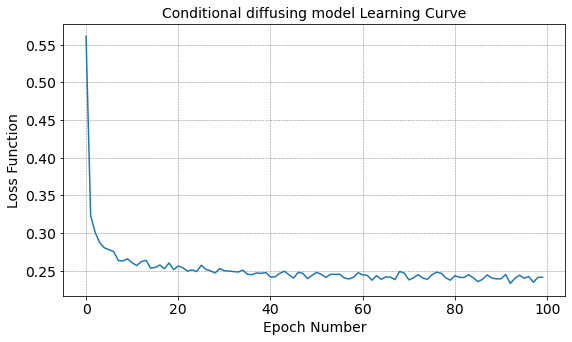

In [37]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [38]:
X_fake_test = generate_with_diffusion(diffusionFitter.model, torch.tensor(y_test, dtype=torch.float), 10, noise_scheduler)
X_fake_train= generate_with_diffusion(diffusionFitter.model, torch.tensor(y_train, dtype=torch.float), 10, noise_scheduler)


1000it [00:14, 70.84it/s]
1000it [00:14, 69.88it/s]


In [39]:
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [41]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.8283681298450578


К счастью, accuracy по мере обучения снижался, значит мы постепенно генерили все более и более хорошие картинки. И даже уже спустя пару эпох логрег не мог отличить генерацию от реальных. А вот бустинг лучше гораздо различал. Поэтому и AUC Roc в этом случае по сравнению с GANом выше - дискриминатор различает картинки лучше. Получается, диффузионная модель для данной задачи оказалась чуть хуже. Но может быть стоит попробовать другие параметры, например какой-то другой лос?

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!

Структура домашки очень плохая, потому что вы сделали для нас отдельные функции, которые надо запихивать в фиттер, но не написали, что эти функции должны делать. Особенно other agent score и generate with diffusion. Из названия особо ничего не следует и приходилось как то по рассуждениям из чата понимать. Более того, у нас вообще существуют ассистенты на этом курсе? В чате ученики отвечают сами себе - ошибки только плодятся, и даже некому написать, спросить, что непонятно.......